<a href="https://colab.research.google.com/github/sezaionurlu/CLTV-Forecast-with-Online-Retail-BG-NBD-and-Gamma-Gamma/blob/main/Online_Retail_BG_NBD_ve_Gamma_Gamma_ile_CLTV_Tahmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##############################################################
# Online Retail BG-NBD ve Gamma-Gamma ile CLTV Tahmini
##############################################################

**İş Problemi**

İngiltere merkezli perakende şirketi satış ve pazarlama
faaliyetleri için roadmap belirlemek istemektedir. Şirketin
orta uzun vadeli plan yapabilmesi için var olan müşterilerin
gelecekte şirkete sağlayacakları potansiyel değerin
tahmin edilmesi gerekmektedir.

**Veri Seti Hikayesi**

Online Retail II isimli veri seti İngiltere merkezli bir perakende şirketinin 01/12/2009 - 09/12/2011 tarihleri
arasındaki online satış işlemlerini içeriyor. Şirketin ürün kataloğunda hediyelik eşyalar yer almaktadır ve çoğu
müşterisinin toptancı olduğu bilgisi mevcuttur.

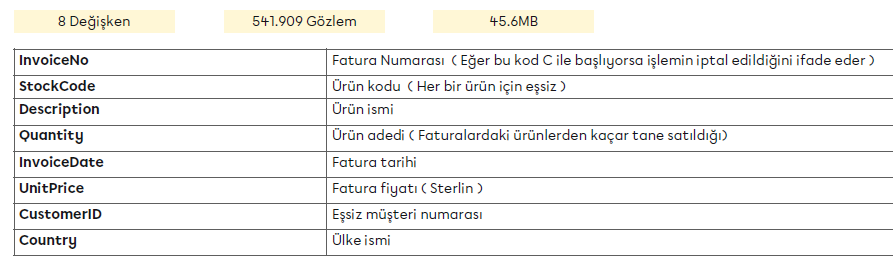

**Proje Görevleri**

*Görev 1: BG-NBD ve Gamma-Gamma Modellerini Kurarak 6 Aylık CLTV Tahmini Yapılması*

In [ ]:
# Adım 1: 2010-2011 yıllarındaki veriyi kullanarak İngiltere’deki müşteriler için 6 aylık CLTV tahmini yapınız.

In [ ]:
df_ = pd.read_excel('/content/drive/MyDrive/Veri Bilimi/online_retail_II.xlsx', sheet_name='Year 2010-2011')

In [ ]:
df = df_.copy()

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0000,9.5522,218.0810,-80995.0000,1.0000,3.0000,10.0000,80995.0000
Price,541910.0000,4.6111,96.7598,-11062.0600,1.2500,2.0800,4.1300,38970.0000
Customer ID,406830.0000,15287.6842,1713.6031,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000


In [ ]:
df.dropna(inplace=True)

In [ ]:
df = df[~df["Invoice"].str.contains("C", na=False)]

In [ ]:
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return round(low_limit, ndigits=0), round(up_limit, ndigits=0)

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0000,11.8296,25.5095,1.0000,2.0000,6.0000,12.0000,298.0000
Price,397885.0000,2.8934,3.2261,0.0010,1.2500,1.9500,3.7500,37.0000
Customer ID,397885.0000,15294.4169,1713.1444,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000


In [ ]:
df["TotalPrice"] = df["Quantity"] * df["Price"]
today_date = dt.datetime(2011, 12, 11)

cltv_df = df.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
         'Invoice': lambda Invoice: Invoice.nunique(),
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

In [ ]:
cltv_df["expected_purc_6_month"] = bgf.predict(4*6,
                                                cltv_df['frequency'],
                                                cltv_df['recency'],
                                                cltv_df['T'])

# 3. GAMMA-GAMMA Modelinin Kurulması
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

# 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
cltv = ggf.customer_lifetime_value(bgf,
                                  cltv_df['frequency'],
                                    cltv_df['recency'],
                                    cltv_df['T'],
                                    cltv_df['monetary'],
                                    time=6,  # 6 aylık
                                    freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv = cltv.reset_index()
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

In [ ]:
cltv_final.sort_values('clv', ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_6_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,73,3645.7085,28.3924,3654.4467,108717.3633
2761,18102.0000,52.2857,52.5714,60,3857.0120,22.8061,3868.2618,92439.0539
843,14096.0000,13.8571,14.5714,17,3163.5424,16.7786,3196.3894,56126.6843
36,12415.0000,44.7143,48.2857,21,5723.7614,8.9251,5771.6321,53971.0160
1257,14911.0000,53.1429,53.4286,201,691.6786,73.6417,692.2948,53420.9813
2458,17450.0000,51.2857,52.5714,46,2861.0689,17.5988,2871.9843,52960.4148
874,14156.0000,51.5714,53.1429,55,2103.8965,20.6651,2110.6236,45702.4706
2487,17511.0000,52.8571,53.4286,31,2933.8684,11.9822,2950.5049,37044.6013
2075,16684.0000,50.4286,51.2857,28,2209.2364,11.2509,2223.1476,26207.6903
650,13694.0000,52.7143,53.4286,50,1275.6430,18.8601,1280.1605,25298.8878


In [ ]:
# Adım 2: Elde ettiğiniz sonuçları yorumlayıp, değerlendiriniz.

*Görev 2: Farklı Zaman Periyotlarından Oluşan CLTV Analizi*

**DİKKAT!**

Sıfırdan model kurulmasına gerek yoktur. Önceki görevde oluşturulan model üzerinden ilerlenebilir.

In [ ]:
# Adım 1: 2010-2011 UK müşterileri için 1 aylık ve 12 aylık CLTV hesaplayınız.

In [ ]:
cltv_1_aylik = ggf.customer_lifetime_value(bgf,
                                  cltv_df['frequency'],
                                    cltv_df['recency'],
                                    cltv_df['T'],
                                    cltv_df['monetary'],
                                    time=1,  # 1 aylık
                                    freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

In [ ]:
cltv_1_aylik.head()

Customer ID
12347.0000   382.8468
12348.0000   182.8058
12352.0000   175.7340
12356.0000   367.8401
12358.0000   330.1298
Name: clv, dtype: float64

In [ ]:
cltv_12_aylik = ggf.customer_lifetime_value(bgf,
                                  cltv_df['frequency'],
                                    cltv_df['recency'],
                                    cltv_df['T'],
                                    cltv_df['monetary'],
                                    time=12,  # 12 aylık
                                    freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

In [ ]:
cltv_12_aylik.head()

Customer ID
12347.0000   4199.7084
12348.0000   2002.6402
12352.0000   1918.2076
12356.0000   4018.4826
12358.0000   3531.1203
Name: clv, dtype: float64

In [ ]:
# Adım 2: 1 aylık CLTV'de en yüksek olan 10 kişi ile 12 aylık'taki en yüksek 10 kişiyi analiz ediniz.

In [ ]:
cltv_1_aylik.sort_values(ascending = False).head(10)

Customer ID
14646.0000   18906.4628
18102.0000   16068.7534
14096.0000    9946.7510
12415.0000    9394.1511
14911.0000    9283.4819
17450.0000    9206.5149
14156.0000    7943.5282
17511.0000    6438.9620
16684.0000    4557.7751
16000.0000    4425.6445
Name: clv, dtype: float64

In [ ]:
cltv_12_aylik.sort_values(ascending = False).head(10)

Customer ID
14646.0000   207526.1430
18102.0000   176513.8493
14096.0000   105745.9606
12415.0000   102949.7757
14911.0000   102032.6636
17450.0000   101125.4895
14156.0000    87278.2419
17511.0000    70741.9458
16684.0000    50025.5589
13694.0000    48315.4614
Name: clv, dtype: float64

In [ ]:
cltv_df.reset_index(inplace=True)

In [ ]:
cltv_df['Customer ID'].astype(int)

0       12347
1       12348
2       12352
3       12356
4       12358
        ...  
2840    18272
2841    18273
2842    18282
2843    18283
2844    18287
Name: Customer ID, Length: 2845, dtype: int64

In [ ]:
cltv_df.loc[cltv_df['Customer ID'].isin([16000, 13694]),:]

,Customer ID,recency,T,frequency,monetary,expected_purc_6_month,expected_average_profit
650,13694.0000,52.7143,53.4286,50,1275.6430,18.8601,1280.1605
1754,16000.0000,0.0000,0.4286,3,2332.3267,9.3767,2476.8387


In [ ]:
# Adım 3: Fark var mı? Varsa sizce neden olabilir?

In [ ]:
# 10. sıra değişti. 1 aylık analizden 12 aylık analize geçildiğinde frequency değeri 50 olan müşteri frequency si 3 olanın üstüne çıktı. Lineer gitmiyor!

*Görev 3: Segmentasyon ve Aksiyon Önerileri*

In [ ]:
# Adım 1: 2010-2011 UK müşterileri için 6 aylık CLTV'ye göre tüm müşterilerinizi 4 gruba (segmente) ayırınız ve grup isimlerini veri setine ekleyiniz.

In [ ]:
cltv_final["segment"] = pd.qcut(cltv_final["expected_purc_6_month"], 4, labels=["D", "C", "B", "A"])

In [ ]:
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_6_month,expected_average_profit,clv,segment
0,12347.0000,52.1429,52.5714,7,615.7143,3.3239,631.9122,2200.7335,B
1,12348.0000,40.2857,51.2857,4,442.5600,2.1618,463.6047,1050.0547,C
2,12352.0000,37.1429,42.4286,8,219.4675,4.2775,224.8101,1007.3700,B
3,12356.0000,43.1429,46.5714,3,937.1433,2.0219,995.9984,2109.6193,C
4,12358.0000,21.2857,21.5714,2,575.0300,2.8279,631.7046,1869.9599,C


In [ ]:
# Adım 2: 4 grup içerisinden seçeceğiniz 2 grup için yönetime kısa kısa 6 aylık aksiyon önerilerinde bulununuz.

In [ ]:
cltv_final['expected_average_profit_6_month'] = cltv_final['expected_average_profit'] * cltv_final['expected_purc_6_month']

In [ ]:
cltv_final.groupby('segment').agg({'expected_average_profit': ['sum', 'mean'],
                                   'expected_purc_6_month' : ['sum', 'mean'],
                                   'expected_average_profit_6_month': ['sum', 'mean']})

expected_average_profit          expected_purc_6_month        expected_average_profit_6_month          
                            sum     mean                   sum   mean                             sum      mean
segment                                                                                                        
D                   256189.8320 359.8172              883.7528 1.2412                     326806.2040  458.9975
C                   280106.9244 393.9619             1764.6915 2.4820                     699300.8351  983.5455
B                   273008.5300 383.9782             2583.0601 3.6330                     991562.8507 1394.6032
A                   306549.5641 431.1527             5161.3780 7.2593                    2511826.0340 3532.8074

In [ ]:
# Önümüzdeki 6' da B grubundan 1394.6032' lik, C grubundan ise 983.5455 bir getiri bekleniyor. Fakat C grubundaki müşterilere kampanyalar düzenlenirse
# B grubundan daha fazla getiri getirebilir.